<a href="https://colab.research.google.com/github/JnKamas/projekt_siete/blob/main/NetSci.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
pip install geodatasets

In [139]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas
from geodatasets import get_path
from shapely.geometry import LineString

In [2]:
!git clone https://github.com/JnKamas/projekt_siete.git

Cloning into 'projekt_siete'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 15 (delta 2), reused 7 (delta 1), pack-reused 0
Receiving objects: 100% (15/15), 371.59 KiB | 7.91 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [244]:
edges = pd.read_csv("projekt_siete/openflights.txt", sep=" ",header = None, names = ['source','target','weight'])

In [245]:
df = pd.read_csv("projekt_siete/openflights_airports.txt", sep=" ")
df.head()

Airport ID                        Name          City           Country  \
0           1                      Goroka        Goroka  Papua New Guinea   
1           2                      Madang        Madang  Papua New Guinea   
2           3                 Mount Hagen   Mount Hagen  Papua New Guinea   
3           4                      Nadzab        Nadzab  Papua New Guinea   
4           5  Port Moresby Jacksons Intl  Port Moresby  Papua New Guinea   

  IATA/FAA  ICAO  Latitude   Longitude  Altitude  Timezone DST  
0      GKA  AYGA -6.081689  145.391881      5282      10.0   U  
1      MAG  AYMD -5.207083  145.788700        20      10.0   U  
2      HGU  AYMH -5.826789  144.295861      5388      10.0   U  
3      LAE  AYNZ -6.569828  146.726242       239      10.0   U  
4      POM  AYPY -9.443383  147.220050       146      10.0   U

<ipython-input-246-7fccf0c40b6d>:7: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  gdf_edges['geometry'] = gdf_edges.apply(lambda row: LineString([(gdf.loc[row['source'], 'geometry'].x, gdf.loc[row['source'], 'geometry'].y),


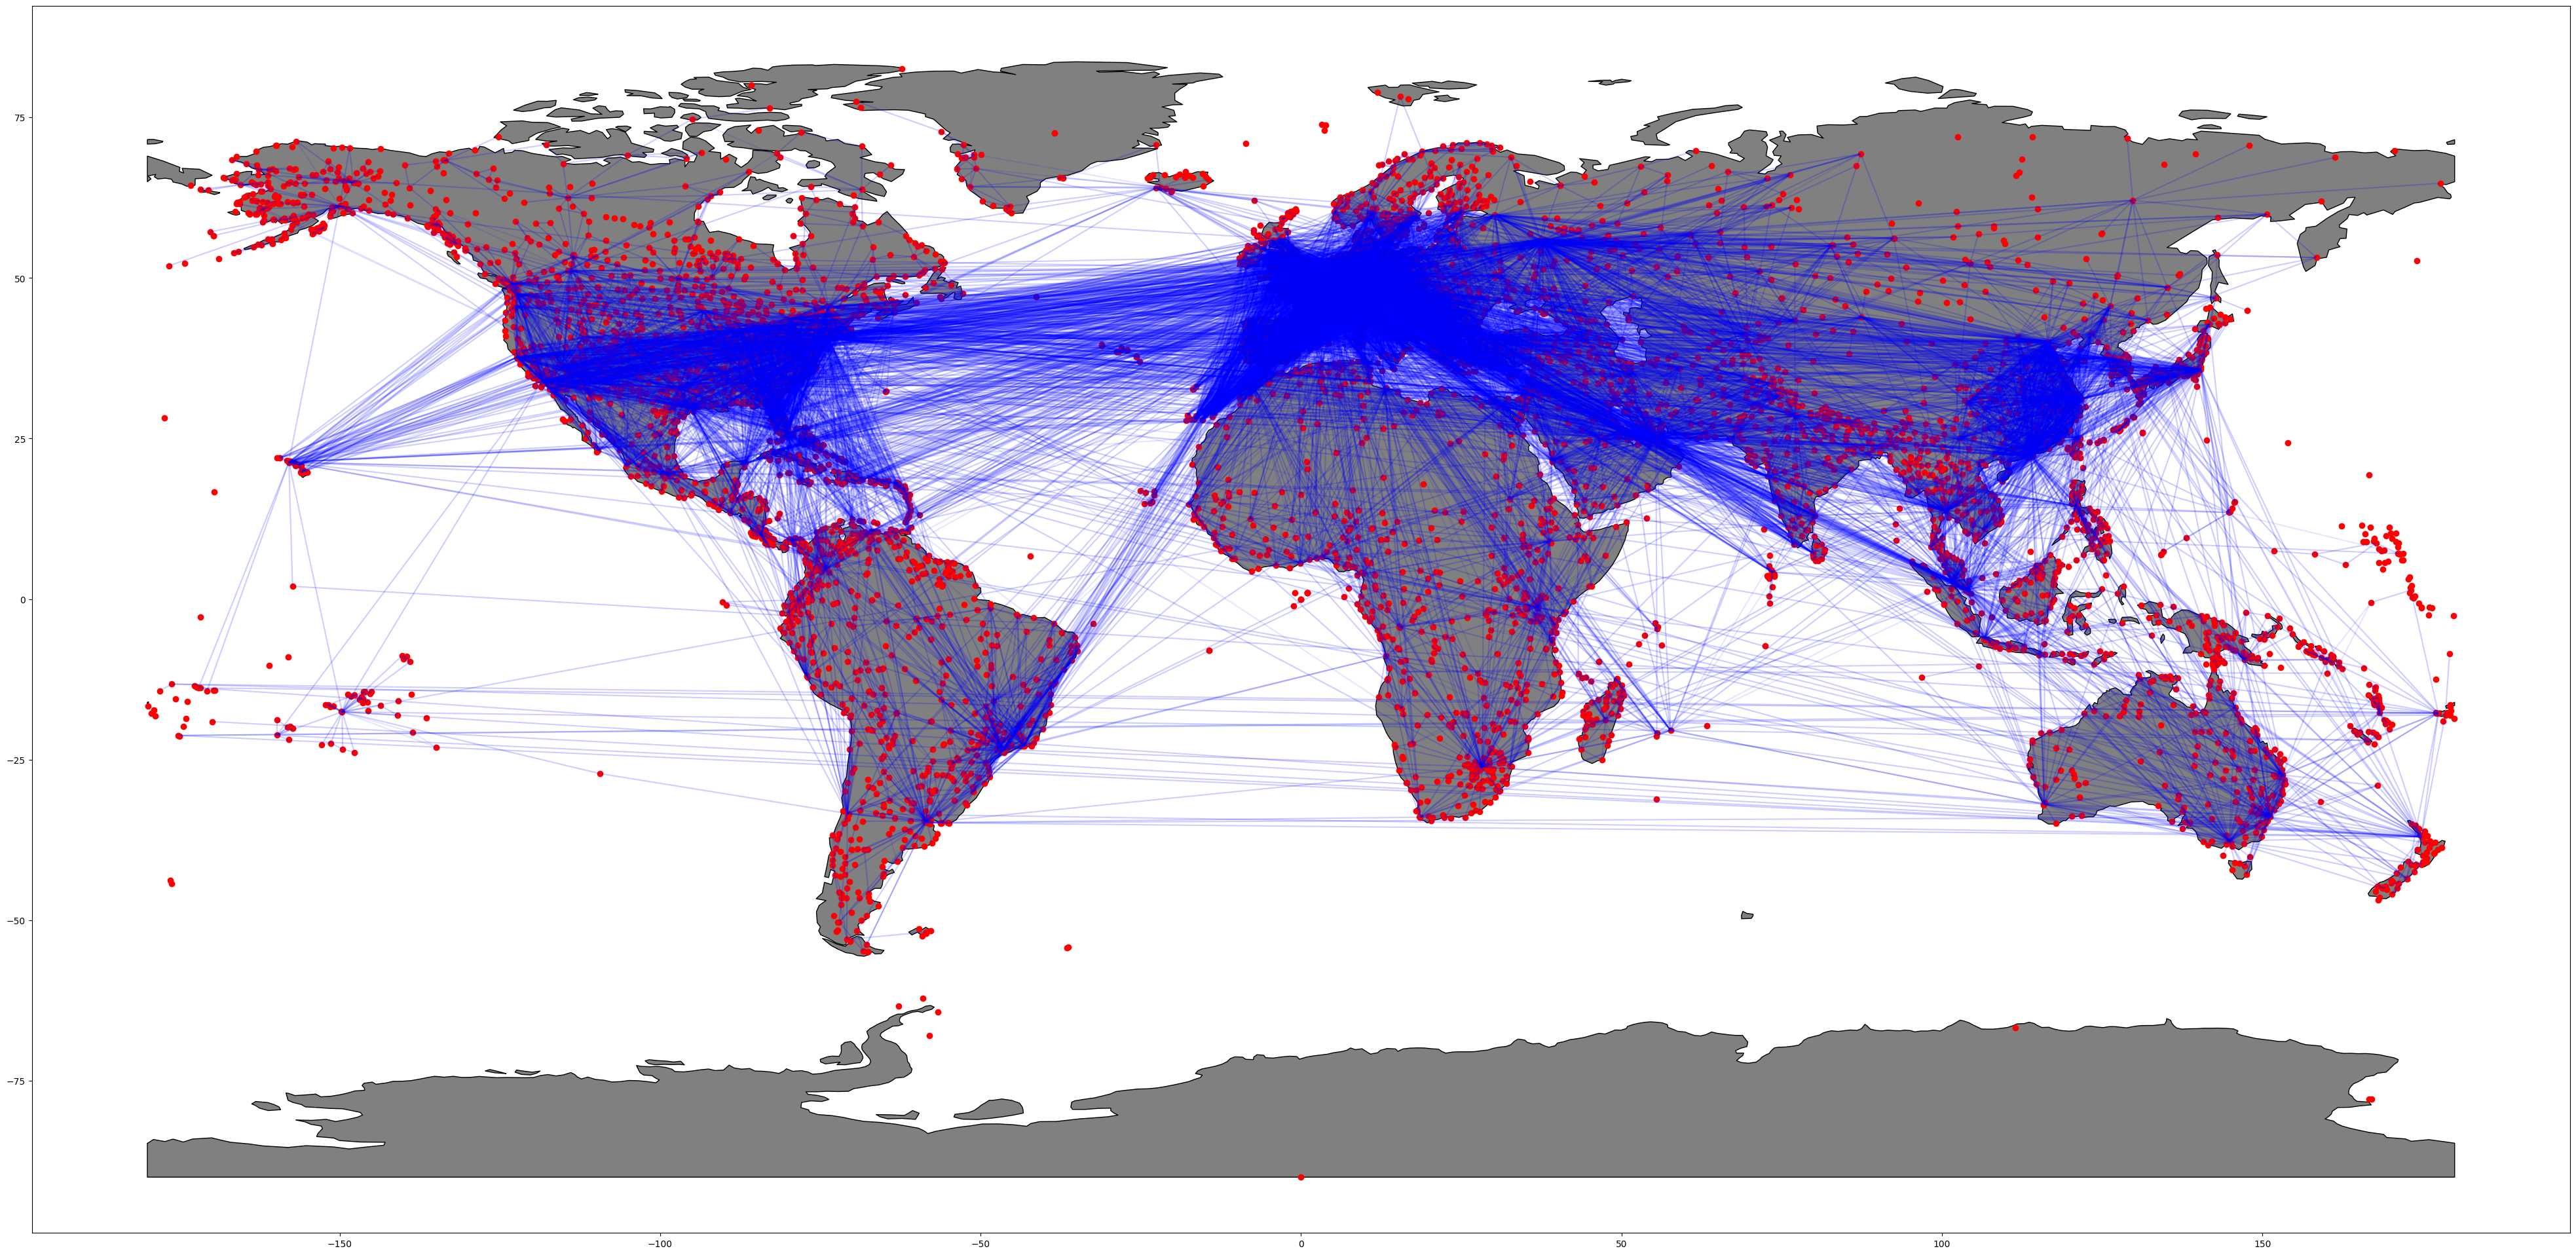

In [246]:
gdf = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df.Longitude, df.Latitude), crs="EPSG:4326")
world = geopandas.read_file(get_path("naturalearth.land"))

#edges
gdf_edges = geopandas.GeoDataFrame(edges)
gdf = gdf.set_index('Airport ID')
gdf_edges['geometry'] = gdf_edges.apply(lambda row: LineString([(gdf.loc[row['source'], 'geometry'].x, gdf.loc[row['source'], 'geometry'].y),
                                                               (gdf.loc[row['target'], 'geometry'].x, gdf.loc[row['target'], 'geometry'].y)]),
                                       axis=1)
gdf = gdf.reset_index()
# Set coordinate reference system if needed
gdf_edges.crs = gdf.crs

# We restrict to South America.
ax = world.plot(color="grey", edgecolor="black", figsize = (50,500))

# We can now plot our ``GeoDataFrame``.
gdf_edges.plot(ax = ax, color = 'blue', alpha = 0.1)
gdf.plot(ax=ax, color="red")

plt.show()

**Základné štatistiky**
ako rozdelenie stupňa vrchola, hustota hrán centralita, blízkosť

*   rozdelenie stupňa vrchola
*   hustota hrán
*   blízkosť



In [247]:
G = nx.from_pandas_edgelist(edges, 'source', 'target',['weight'],create_using = nx.DiGraph())
verticesNotIncludedInEdgeList = np.setdiff1d( df['Airport ID'], np.union1d(edges['source'],edges['target']))
G.add_nodes_from(verticesNotIncludedInEdgeList)

In [248]:
# Adjacency matrix nie je symeytricka
adj_mat = nx.adjacency_matrix(G)
(adj_mat.T != adj_mat).sum()

2630

In [249]:
df = df.sort_values(by = 'Airport ID')
df['in_degree'] = list(dict(sorted(dict(G.in_degree()).items())).values())
df['out_degree'] = list(dict(sorted(dict(G.out_degree()).items())).values())
df['degree'] = df['out_degree'] + df['in_degree']

Text(0.5, 0.98, 'Degree distribution for all vertices')

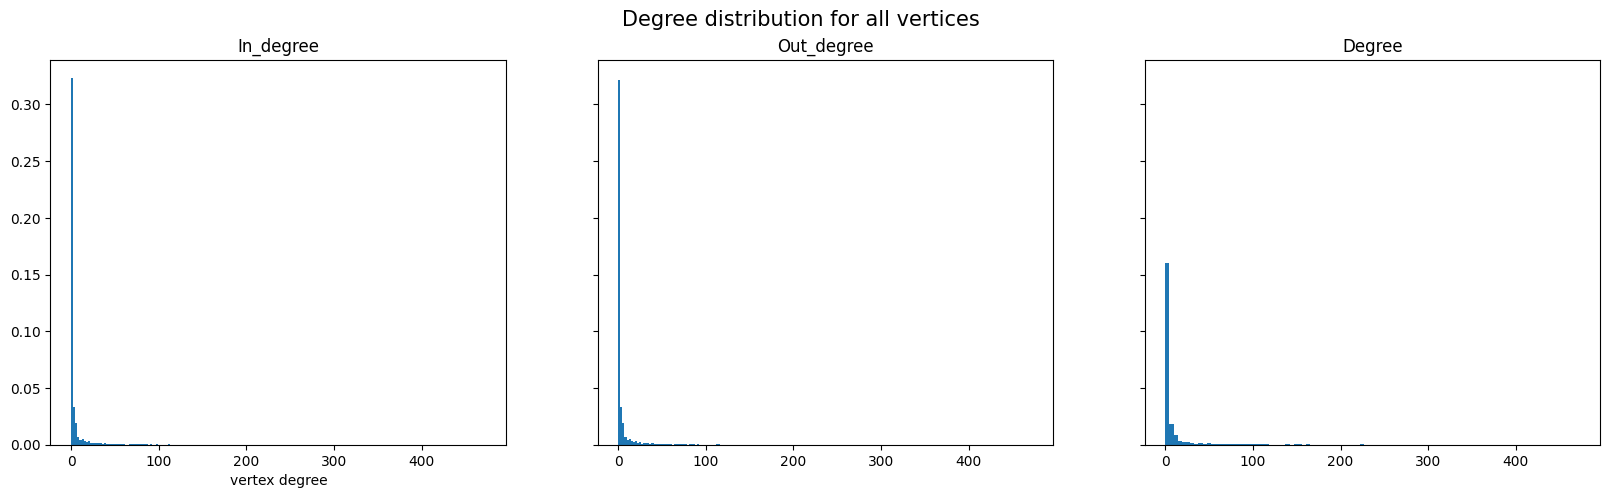

In [250]:
fig,ax = plt.subplots(1,3,figsize = (20,5), sharex = True, sharey = True)
graph_in = ax[0].hist(df['in_degree'] , 100, density = 1)
graph_out = ax[1].hist(df['out_degree'] , 100, density = 1)
graph = ax[2].hist(df['degree'] , 100, density = 1)

ax[0].set_title('In_degree')
ax[1].set_title('Out_degree')
ax[2].set_title('Degree')

ax[0].set_xlabel('vertex degree')
fig.suptitle('Degree distribution for all vertices',fontsize = 15)

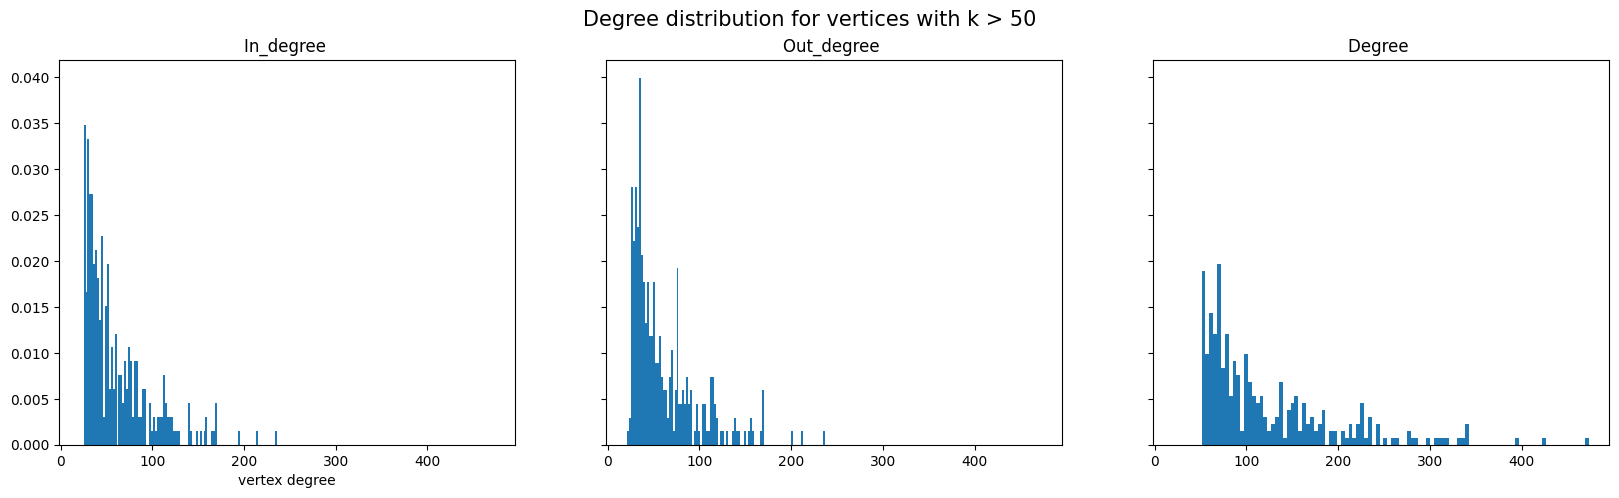

In [251]:
fig,ax = plt.subplots(1,3,figsize = (20,5), sharex = True, sharey = True)
high_degrees = df[df['degree'] > 50]
graph_in = ax[0].hist(high_degrees['in_degree'] , 100, density = 1)
graph_out = ax[1].hist(high_degrees['out_degree'] , 100, density = 1)
graph = ax[2].hist(high_degrees['degree'] , 100, density = 1)

ax[0].set_title('In_degree ')
ax[1].set_title('Out_degree ')
ax[2].set_title('Degree ')

ax[0].set_xlabel('vertex degree')
fig.suptitle('Degree distribution for vertices with k > 50',fontsize = 15)
plt.show()

In [241]:
# 5 vertices with highest degree
df.sort_values(by = 'degree', ascending = False).head()

Airport ID               Name       City         Country IATA/FAA  ICAO  \
337          340     Frankfurt Main  Frankfurt         Germany      FRA  EDDF   
1358        1382  Charles De Gaulle      Paris          France      CDG  LFPG   
575          580           Schiphol  Amsterdam     Netherlands      AMS  EHAM   
3268        3364       Capital Intl    Beijing           China      PEK  ZBAA   
498          502            Gatwick     London  United Kingdom      LGW  EGKK   

       Latitude   Longitude  Altitude  Timezone DST  in_degree  out_degree  \
337   50.026421    8.543125       364       1.0   E        236         237   
1358  49.012779    2.550000       392       1.0   E        213         213   
575   52.308613    4.763889       -11       1.0   E        194         201   
3268  40.080111  116.584556       116       8.0   U        170         170   
498   51.148056   -0.190278       202       0.0   E        169         170   

      degree  
337      473  
1358     426  
575      395  
3268     340  
498      339